In [1]:
#Install packages

!pip install rasterio
!pip install git+https://github.com/requests/requests.git
!pip install segmentation_models_pytorch
!pip install torchinfo
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 33.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/requests/requests.git to /tmp/pip-req-build-5r63_7v4
  Running command git clone --filter=blob:none --quiet https://github.com/requests/requests.git /tmp/pip-req-build-5r63_7v4
  Resolved https://github.com/requests/requests.git to commit 2ad18e0e10e7d7ecd5384c378f25ec8821a10a29
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for requests: filename=requests-2.30.0-py3-none-any.whl size=62498 sha256=b95bf8171b8af38f4a1f8ae7341e0019dd11752d555e36f69195358f25d8ba6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-itv91gzd/wheels/cf/fd/e5/ad639e794ab30b60b94b9d14119269223f4b018bb3e1476

In [2]:
import requests
import rasterio
from rasterio.io import MemoryFile
from google.colab import drive
from rasterio.plot import show
import torch
import numpy as np
from rasterio.plot import show
from rasterio.windows import Window

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#open our image
image = '/content/image_to_modelDL13.tif'

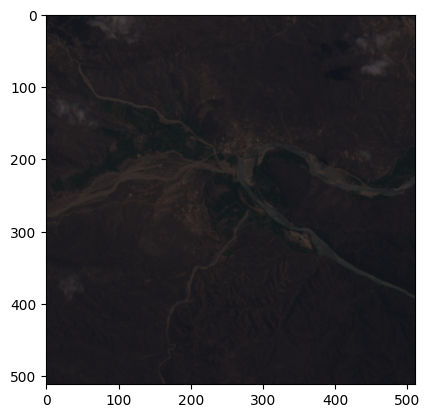

<Axes: >

In [7]:
#Open our image 
src = rasterio.open(image)

#create a 512x512 pixel widow
win = Window.from_slices((0, 512), (0, 512))

#set the RGB combination and visualize
data = src.read([4, 3, 2], window=win)

show(data)

In [8]:
#Import the model
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=13,
    classes=4
)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 119MB/s]


In [10]:
#Match the model with our trained parameters

model.load_state_dict(torch.load('/content/model.pt'))

<All keys matched successfully>

In [ ]:
model.eval()

In [12]:
#Call our imageto predict
src = rasterio.open(image)
data = src.read(window=win)

In [13]:
#convert our image into a tensor
data_t = torch.from_numpy(data).type(torch.float)

print(data_t.shape)
print(data_t.size())

torch.Size([13, 512, 511])
torch.Size([13, 512, 511])


In [14]:
#add a padding to keep our tensor' size
import torch.nn.functional as F

data_t_padded = F.pad(data_t, (0, 1, 0, 0), mode='constant', value=0)

print(data_t_padded.shape)
print(data_t_padded.size())

torch.Size([13, 512, 512])
torch.Size([13, 512, 512])


In [15]:
#add an extra dimention
d = data_t_padded.unsqueeze(0)
print(d.shape)

torch.Size([1, 13, 512, 512])


In [16]:
 #appy the model to our image
 y_pred = model(d.cuda())

In [17]:
#convert it into a numpy array
y_np = y_pred.detach().cpu().numpy()

In [18]:
#check the shape
y_np.shape

(1, 4, 512, 512)

In [19]:
#quitarle una dimension
y_sq = np.squeeze(y_np)
y_sq.shape

(4, 512, 512)

In [20]:
#apply the argmax function
y_pred_argmax = np.argmax(y_sq,axis = 0)

In [21]:
y_pred_argmax.shape


(512, 512)

In [23]:
import matplotlib.pyplot as plt

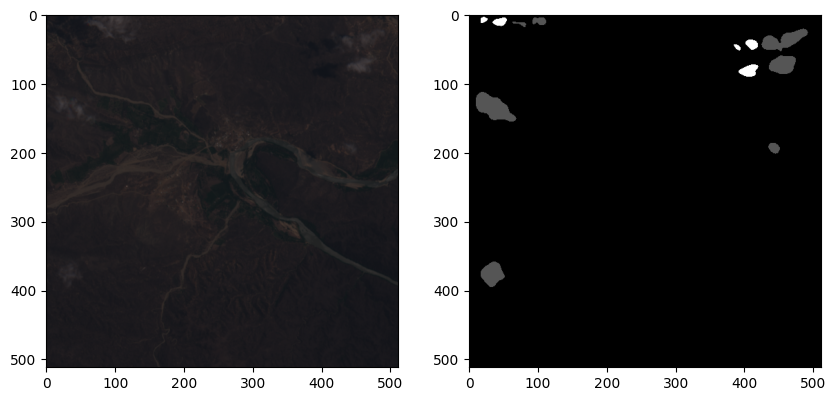

In [24]:
#ploting

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(torch.moveaxis(data_t_padded[[3, 2, 1]], 0, 2))
ax[1].imshow(y_pred_argmax, cmap="gray")